<a href="https://colab.research.google.com/github/abixhxkx/Financial_sentiment_analysis/blob/main/Financial_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc # pour optimiser la memoire

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#df = pd.read_csv("/Users/yosrnoureddine/Downloads/all-data.csv", delimiter=',', encoding='latin-1', header=None)
df = pd.read_csv("/Users/abixh/Downloads/Financial_sentiment_analysis_DEEP_LEANING_GROUP_PROJECT/all-data.csv, delimiter=',', encoding='latin-1', header=None)
df.columns = ["Sentiment", "Message"]
df.head()

,Sentiment,Message
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
df.shape

(4846, 2)

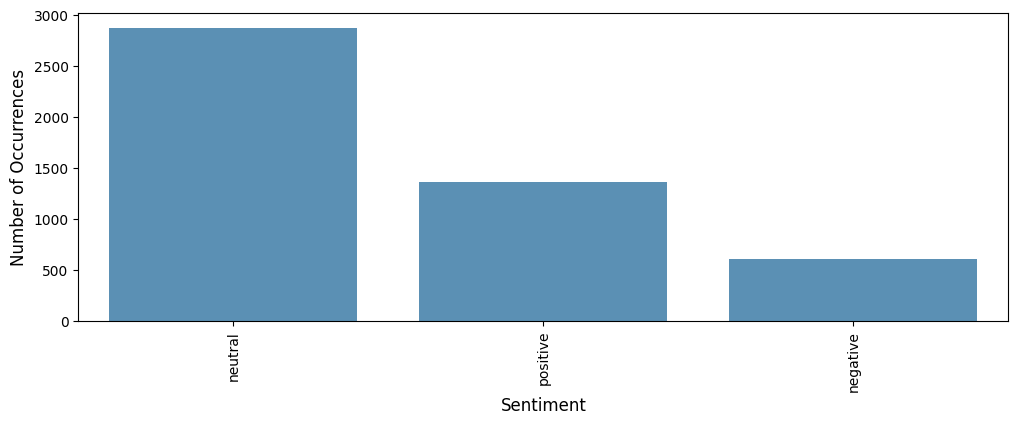

In [ ]:
cnt_pro = df['Sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=cnt_pro.index, y=cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [ ]:
#Convert string to numeric
Sentiment  = {'positive': 0,'neutral': 1,'negative':2}

df.Sentiment = [Sentiment[item] for item in df.Sentiment]
print(df)

      Sentiment                                            Message
0             1  According to Gran , the company has no plans t...
1             1  Technopolis plans to develop in stages an area...
2             2  The international electronic industry company ...
3             0  With the new production plant the company woul...
4             0  According to the company 's updated strategy f...
...         ...                                                ...
4841          2  LONDON MarketWatch -- Share prices ended lower...
4842          1  Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843          2  Operating profit fell to EUR 35.4 mn from EUR ...
4844          2  Net sales of the Paper segment decreased to EU...
4845          2  Sales in Finland decreased by 10.5 % in Januar...

[4846 rows x 2 columns]


In [ ]:
def print_message(index):
    example = df[df.index == index][['Message', 'Sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Sentiment:', example[1])
print_message(12)

A purchase agreement for 7,200 tons of gasoline with delivery at the Hamina terminal , Finland , was signed with Neste Oil OYj at the average Platts index for this September plus eight US dollars per month .
Sentiment: 0


In [ ]:
print_message(0)

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Sentiment: 1


In [ ]:
import re
from bs4 import BeautifulSoup

def clean_financial_text(text):
    """
    Cleans text for a FinBERT-style model.
    Focuses on removing noise and normalizing, not over-processing.
    """
    # 1. Remove HTML tags
    text = BeautifulSoup(text, "lxml").text

    # 2. Replace URLs with a special <URL> token
    text = re.sub(r'http\S+', r'<URL>', text)


    # 3. Normalize stock tickers.
    # We add a space to help the tokenizer. '$AAPL' -> ' $AAPL '
    # The model will learn what $ means in context.
    # An alternative: re.sub(r'\$([A-Z]+)', r'ticker \1', text)
    text = re.sub(r'(\$[A-Z]+)', r' \1 ', text)

    # 4. Normalize numbers (optional but can help)
    # This groups all numbers into one token.
    # e.g., "profit of 1,000,000" -> "profit of <NUM>"
    # text = re.sub(r'(\d+[\d.,]*%?)', r' <NUM> ', text)

    # 5. Remove any specific artifacts (like your |||)
    text = re.sub(r'\|\|\|', r' ', text)

    # 6. Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # --- THINGS WE DO NOT DO ---
    #
    # We DO NOT convert to lowercase (let the "uncased" tokenizer handle it).
    # We DO NOT remove punctuation (BERT understands "!" and "?").
    # We DO NOT remove stop words ("not good" is very different from "good").
    # We DO NOT perform stemming/lemmatization (BERT understands "grew" vs "growing").

    return text

# Example usage:
# df['Message'] = df['Message'].apply(clean_financial_text)

In [ ]:
from sklearn.model_selection import train_test_split
df['Message'] = df['Message'].apply(clean_financial_text)
train, test = train_test_split(df, test_size=0.1 , random_state=42)

In [ ]:
# Display dataset size and first samples
print("Total number of rows:", len(df))
df.head(10)


Total number of rows: 4846


,Sentiment,Message
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,2,The international electronic industry company ...
3,0,With the new production plant the company woul...
4,0,According to the company 's updated strategy f...
5,0,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
6,0,"For the last quarter of 2010 , Componenta 's n..."
7,0,"In the third quarter of 2010 , net sales incre..."
8,0,Operating profit rose to EUR 13.1 mn from EUR ...
9,0,"Operating profit totalled EUR 21.1 mn , up fro..."


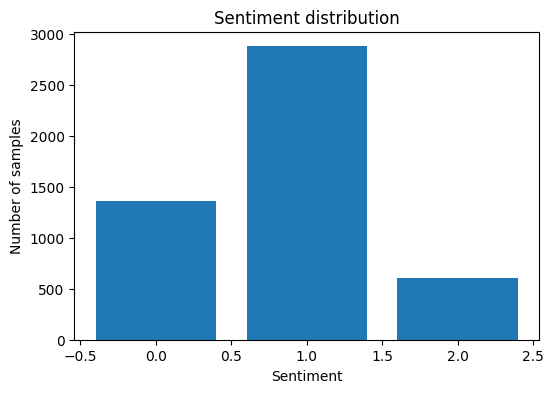

In [ ]:
import matplotlib.pyplot as plt

# Count samples per sentiment class, this helps us see if the dataset is balanced or not.

sentiment_counts = df['Sentiment'].value_counts()

plt.figure(figsize=(6,4))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel("Sentiment")
plt.ylabel("Number of samples")
plt.title("Sentiment distribution")
plt.show()


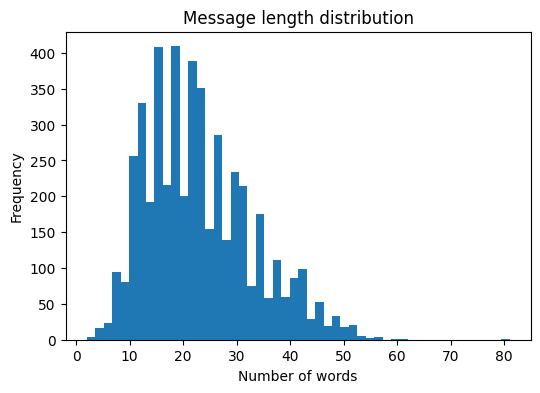

count    4846.000000
mean       23.101114
std         9.958474
min         2.000000
25%        16.000000
50%        21.000000
75%        29.000000
max        81.000000
Name: length, dtype: float64


In [ ]:
# Compute number of words in each message short or very long messages can affect model performance.

df['length'] = df['Message'].apply(lambda x: len(x.split()))

plt.figure(figsize=(6,4))
plt.hist(df['length'], bins=50)
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.title("Message length distribution")
plt.show()

# Summary statistics on message length
print(df['length'].describe())


In [ ]:
import re
from collections import Counter

# Tokenization: extract word tokens (simple regex tokenizer) it gives an idea of the vocabulary used in financial texts.
def tokenize(text):
    tokens = re.findall(r"\b\w+\b", text.lower())
    return tokens

# Apply tokenization
df['tokens'] = df['Message'].apply(tokenize)

# Flatten all tokens into one list
all_words = [word for tokens in df['tokens'] for word in tokens]
word_counts = Counter(all_words)

print("Top 20 most frequent words:")
print(word_counts.most_common(20))


Top 20 most frequent words:
[('the', 6069), ('of', 3215), ('in', 2984), ('and', 2596), ('to', 2523), ('a', 1748), ('for', 1152), ('s', 1089), ('eur', 1018), ('is', 930), ('company', 851), ('will', 850), ('from', 769), ('on', 727), ('its', 646), ('has', 578), ('with', 573), ('by', 559), ('said', 545), ('as', 544)]


# Task
Generate a word cloud visualization from the `word_counts` object, and then provide a summary of the generated word cloud, highlighting prominent words and their potential significance in the financial context.

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

print("WordCloud and matplotlib.pyplot imported successfully.")

WordCloud and matplotlib.pyplot imported successfully.


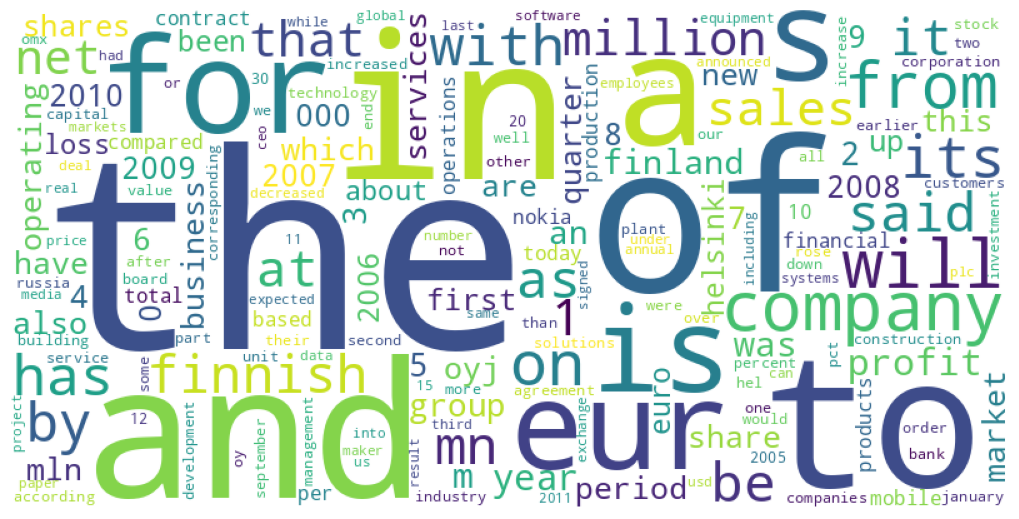

Word Cloud generated and displayed successfully.


In [ ]:


# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 400,
                background_color ='white',
                min_font_size = 10).generate_from_frequencies(word_counts)

# Display the generated image:
plt.figure(figsize = (10, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

print("Word Cloud generated and displayed successfully.")

In [ ]:
print("Example positive message:\n", df[df.Sentiment==0].Message.iloc[0])
print("\nExample neutral message:\n", df[df.Sentiment==1].Message.iloc[0])
print("\nExample negative message:\n", df[df.Sentiment==2].Message.iloc[0])


Example positive message:
 With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .

Example neutral message:
 According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .

Example negative message:
 The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .


In [ ]:
gc.collect()


11545

In [ ]:
from sklearn.model_selection import train_test_split

# First split: Train (80%) + Temp (20%)
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['Sentiment'] # keeps class balance
)

# Second split: Validation (10%) + Test (10%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['Sentiment']
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))


Train size: 3876
Validation size: 485
Test size: 485


The first step is to install the `transformers` library as requested in the instructions.



In [ ]:
#pip install transformers

The next step is to install the `torch` library, as specified in the instructions.



In [ ]:
#pip install torch

In [ ]:
print("Cleaned 'Message' column for train_df:")
print(train_df[['Message']].head())
print("\nCleaned 'Message' column for val_df:")
print(val_df[['Message']].head())
print("\nCleaned 'Message' column for test_df:")
print(test_df[['Message']].head())

Cleaned 'Message' column for train_df:
                                                Message
832   DMASIA-16 August 2006-Benefon extends manufact...
2095                European traffic grew nearly 30 % .
3603  Garmin fell 4.5 percent to $ 34.53 at 1:33 p.m...
492   HELSINKI AFX - KCI Konecranes said it has rais...
3785  The Committee proposes the following remunerat...

Cleaned 'Message' column for val_df:
                                                Message
4661  Cargo traffic fell 1 % year-on-year to 8,561 t...
2926  Glaston 's own glass processing unit , Tamglas...
2890             Financial details were n't disclosed .
2244  The solvency capital ratio of both companies w...
2020  In the beginning of this year , Wartsila had s...

Cleaned 'Message' column for test_df:
                                                Message
4610  At 12.01 pm , the OMX Helsinki 25 was down 0.6...
3361  The share subscription period for stock option...
1750  EuroChem CFO Andrey Ilyin said : `` Th

## Load Tokenizer and Prepare Data

Load the FinBERT tokenizer and use it to tokenize and encode the 'Message' column of your `train_df`, `val_df`, and `test_df`. Convert the tokenized data and sentiment labels into PyTorch TensorDatasets and DataLoaders, which are required for model training.


**Reasoning**:
The first step is to import the `AutoTokenizer` class from the `transformers` library and then load the pre-trained FinBERT tokenizer using `AutoTokenizer.from_pretrained()`, as specified in the instructions.



In [ ]:
from transformers import AutoTokenizer
import torch
from torch.utils.data import TensorDataset, DataLoader

# Load the FinBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')

print("FinBERT tokenizer loaded successfully.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


FinBERT tokenizer loaded successfully.


**Reasoning**:
The previous step successfully loaded the FinBERT tokenizer. Now, I will proceed to tokenize and encode the 'Message' column for the train, validation, and test dataframes using the loaded tokenizer. Then, I will convert the tokenized data and sentiment labels into PyTorch TensorDatasets and DataLoaders, as specified in the instructions.



In [ ]:
BATCH_SIZE = 16

def encode_data(tokenizer, dataframe):
    messages = dataframe['Message'].tolist()
    labels = dataframe['Sentiment'].tolist()

    # Tokenize and encode messages
    encoded_inputs = tokenizer(
        messages,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoded_inputs['input_ids']
    attention_mask = encoded_inputs['attention_mask']
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return TensorDataset(input_ids, attention_mask, labels_tensor)

# Encode datasets
train_dataset = encode_data(tokenizer, train_df)
val_dataset = encode_data(tokenizer, val_df)
test_dataset = encode_data(tokenizer, test_df)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Data tokenization, encoding, and DataLoader creation completed.")
print(f"Train DataLoader has {len(train_dataloader)} batches.")
print(f"Validation DataLoader has {len(val_dataloader)} batches.")
print(f"Test DataLoader has {len(test_dataloader)} batches.")

Data tokenization, encoding, and DataLoader creation completed.
Train DataLoader has 243 batches.
Validation DataLoader has 31 batches.
Test DataLoader has 31 batches.


## Load FinBERT Model for Sequence Classification

### Subtask:
Load the pre-trained FinBERT model for sequence classification from the `transformers` library. Configure the model with the correct number of output labels (corresponding to our sentiment categories).



The first step is to import the `AutoModelForSequenceClassification` class from the `transformers` library, determine the number of unique sentiment labels, and then load the pre-trained FinBERT model for sequence classification, as specified in the instructions. This prepares the model for further training or evaluation.



In [ ]:
from transformers import AutoModelForSequenceClassification

# Determine the number of unique sentiment labels
num_labels = df['Sentiment'].nunique()

# Load the pre-trained FinBERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert', num_labels=num_labels)

print(f"FinBERT model loaded with {num_labels} output labels.")

FinBERT model loaded with 3 output labels.


**Reasoning**:
The previous step successfully loaded the FinBERT model. Now, I need to define the computation device (GPU if available, otherwise CPU) and move the loaded model to this device, as instructed.



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Model moved to device: {device}")

Model moved to device: cpu


## Define Training Parameters and Functions

### Subtask:
Set up the device (GPU if available), define the optimizer (e.g., AdamW) and a learning rate scheduler. Implement helper functions for a single training epoch and for evaluating the model on a given dataset.



The first step is to import the `AdamW` optimizer from `transformers.optimization` and the `get_linear_schedule_with_warmup` function from `transformers.get_scheduler` to prepare for defining the optimizer and scheduler.



In [ ]:
from torch.optim import AdamW
from transformers import get_scheduler

print("Imported AdamW from torch.optim and get_scheduler from transformers.")

Imported AdamW from torch.optim and get_scheduler from transformers.


**Reasoning**:
Now that the necessary imports are done, I will define the `AdamW` optimizer for the model's parameters with a learning rate of 2e-5, and then define the learning rate scheduler using `get_linear_schedule_with_warmup` as specified in the instructions. This requires calculating the total number of training steps.



In [ ]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)

num_epochs = 3 # Example number of epochs, you can adjust this
total_steps = len(train_dataloader) * num_epochs

scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"Optimizer initialized with learning rate: {learning_rate}")
print(f"Learning rate scheduler initialized for {total_steps} total training steps.")

Optimizer initialized with learning rate: 5e-05
Learning rate scheduler initialized for 729 total training steps.



Now that the optimizer and scheduler are defined, the next step is to implement the `train_epoch` helper function, as specified in the instructions. This function will encapsulate the logic for a single pass through the training data, handling forward and backward propagation, loss calculation, and parameter updates.



In [ ]:
import torch.nn as nn

def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()  # Set the model to training mode
    total_loss = 0
    for batch_idx, batch in enumerate(dataloader):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()  # Clear previous gradients

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

print("train_epoch function defined.")

train_epoch function defined.


**Reasoning**:
The `train_epoch` function has been defined. Now, I need to implement the `evaluate_model` helper function to assess the model's performance on a given dataset, as specified in the instructions. This function will calculate the average loss and accuracy.



In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader

def evaluate_model(model, dataset, device, batch_size=16):
    model.eval()  # Mode évaluation
    total_loss = 0
    all_predictions = []
    all_true_labels = []
    dataloader = DataLoader(dataset, batch_size=batch_size)

    with torch.no_grad():  # Pas de calcul de gradients
        for batch in dataloader:
            # Si batch est tuple (input_ids, attention_mask, labels)
            # Sinon adapter ce déballage selon structure de batch
            if isinstance(batch, dict) or hasattr(batch, 'keys'):
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'label'}
                labels = batch['label'].to(device)
            else:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            preds = torch.argmax(logits, dim=-1).cpu().numpy()
            true_labels = labels.cpu().numpy()

            all_predictions.extend(preds)
            all_true_labels.extend(true_labels)

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_true_labels, all_predictions)
    f1 = f1_score(all_true_labels, all_predictions, average='weighted')

    return {'loss': avg_loss, 'accuracy': accuracy, 'f1_score': f1}


In [ ]:
# Device setup (force CPU for lightweight requirement)
device = torch.device('cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Train the FinBERT Model

### Subtask:
Execute the training loop for multiple epochs. In each epoch, train the model on the training data and evaluate its performance on the validation data to monitor progress and prevent overfitting.


Now that the `train_epoch` and `evaluate_model` functions are defined, I will execute the main training loop. This loop will iterate for a predefined number of epochs, training the model on the training dataset and evaluating its performance on the validation dataset in each epoch. I will track and print the training loss, validation loss, and validation accuracy to monitor the model's progress and detect potential overfitting.

**Reasoning**:
I will initialize variables to store the training history, then execute the main training loop for the specified number of epochs, calling the `train_epoch` and `evaluate_model` functions, and printing the loss and accuracy for each epoch as instructed.



In [ ]:
# Initialize metric tracking lists
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []

# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    avg_train_loss = train_epoch(model, train_dataloader, optimizer, scheduler, device)
    train_losses.append(avg_train_loss)

    eval_results = evaluate_model(model, val_dataloader, device)
    val_losses.append(eval_results['loss'])
    val_accuracies.append(eval_results['accuracy'])
    val_f1_scores.append(eval_results['f1_score'])

    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {eval_results['loss']:.4f}")
    print(f"Validation Accuracy: {eval_results['accuracy']:.4f}")
    print(f"Validation F1 Score: {eval_results['f1_score']:.4f}")

print("\nTraining complete!")



Epoch 1/3


In [ ]:
# Let test our model on unknown data (test set)
final_results = evaluate_model(model, test_dataset, device)
print("Performance finale sur test :", final_results)


# FINE TUNING PART